In [ ]:
!pip install torch_geometric
!pip install --verbose --no-cache-dir torch-scatter
!pip install --verbose --no-cache-dir torch-sparse
!pip install --verbose --no-cache-dir torch-cluster
!pip install tensorboradX



In [57]:
# !wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
# !unzip ngrok-stable-linux-amd64.zip
!ls ./log

20201008-093445  20201008-093703  20201008-093829  20201008-094026
20201008-093507  20201008-093745  20201008-093910  20201008-094312


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader
import torch_geometric.transforms as T

import time
from datetime import datetime

import networkx as nx
import numpy as np

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [32]:

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task="node"):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        for li in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), nn.Linear(hidden_dim, output_dim)
        )

        if not (self.task == "node" or self.task == "graph"):
            raise RuntimeError("Unknown task")

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == "node":
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(
                nn.Sequential(
                    nn.Linear(input_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)
                )
            )

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
            x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        if self.task == "graph":
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)


#custom conv

In [33]:


class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(arg="add")  # 'Add' aggregation
        self.lin = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix
        edge_index, _ = pyg_utils.add_self_loops(edge_index, num_nodes=x.size(0))

        x = self.lin(x)

        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)

    def message(self, x_j, edge_index, size):  # x_i, x_j is ok
        # compute message
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]

        return aggr_out


In [38]:


def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == "node":
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]

        correct += pred.eq(label).sum().item()

    if model.task == "graph":
        total = len(loader.dataset)
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()

    return correct / total


In [43]:

def train(dataset, task, writer):
    if task == "graph":
        data_size = len(dataset)
        loader = DataLoader(dataset[: int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8) :], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)

    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == "node":
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch)

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print(
                "Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(epoch, total_loss, test_acc)
            )
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model


In [ ]:

get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'.format('./log')
)
get_ipython().system_raw('./ngrok http 6006 &')
!curl -s https://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [ ]:

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root="/tmp/IMDB-BINARY", name="IMDB-BINARY")
dataset = dataset.shuffle()
task = "graph"

model = train(dataset, task, writer)

Epoch 0. Loss: 1.6587. Test accuracy: 0.4000
Epoch 10. Loss: 0.6700. Test accuracy: 0.6250
Epoch 20. Loss: 0.6088. Test accuracy: 0.6800
Epoch 30. Loss: 0.5840. Test accuracy: 0.6850
Epoch 40. Loss: 0.5798. Test accuracy: 0.6950


In [44]:

writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root="/tmp/citeseer", name="citeseer")
task = "node"

model = train(dataset, task, writer)


Epoch 0. Loss: 1.7974. Test accuracy: 0.2390
Epoch 10. Loss: 0.5996. Test accuracy: 0.6030
Epoch 20. Loss: 0.1109. Test accuracy: 0.6320
Epoch 30. Loss: 0.1667. Test accuracy: 0.6280
Epoch 40. Loss: 0.0383. Test accuracy: 0.5670
Epoch 50. Loss: 0.0109. Test accuracy: 0.5950
Epoch 60. Loss: 0.0633. Test accuracy: 0.5980
Epoch 70. Loss: 0.0078. Test accuracy: 0.6160
Epoch 80. Loss: 0.0162. Test accuracy: 0.6110
Epoch 90. Loss: 0.0118. Test accuracy: 0.6040
Epoch 100. Loss: 0.0007. Test accuracy: 0.6120
Epoch 110. Loss: 0.0107. Test accuracy: 0.6190
Epoch 120. Loss: 0.0122. Test accuracy: 0.6070
Epoch 130. Loss: 0.0047. Test accuracy: 0.5930
Epoch 140. Loss: 0.0085. Test accuracy: 0.6120
Epoch 150. Loss: 0.0062. Test accuracy: 0.6050
Epoch 160. Loss: 0.0010. Test accuracy: 0.6120
Epoch 170. Loss: 0.0002. Test accuracy: 0.6140
Epoch 180. Loss: 0.0025. Test accuracy: 0.5940
Epoch 190. Loss: 0.0226. Test accuracy: 0.6020


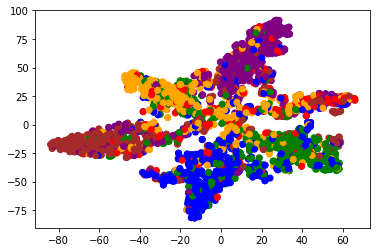

In [46]:

color_list = ["red", "orange", "green", "blue", "purple", "brown"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)
